**Samin Mehdizadeh** / **Mohsen Fayyaz**

In [ ]:
# ! wget https://physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip
# ! unzip /content/mit-bih-arrhythmia-database-1.0.0.zip

In [ ]:
! pip install wfdb
! pip install spectrum
! python -m pip uninstall matplotlib
! pip install matplotlib==3.1.3

In [ ]:
import wfdb
import spectrum
import matplotlib.pyplot as plt
import numpy as np
from pylab import plot, log10, linspace, axis
from tqdm.auto import tqdm
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

## Download database & Test for an example

In [ ]:
import os
wfdb.dl_database('mitdb', os.path.join(os.getcwd(), 'mitdb'))
wfdb.dl_database('chfdb', os.path.join(os.getcwd(), 'chfdb'))

Finished downloading files


{'record_name': '100', 'n_sig': 2, 'fs': 360, 'counter_freq': None, 'base_counter': None, 'sig_len': 1000, 'base_time': None, 'base_date': None, 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'], 'sig_name': ['MLII', 'V5'], 'p_signal': array([[-0.145, -0.065],
       [-0.145, -0.065],
       [-0.145, -0.065],
       ...,
       [-0.385, -0.26 ],
       [-0.375, -0.26 ],
       [-0.385, -0.275]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['100.dat', '100.dat'], 'fmt': ['212', '212'], 'samps_per_frame': [1, 1], 'skew': [None, None], 'byte_offset': [None, None], 'adc_gain': [200.0, 200.0], 'baseline': [1024, 1024], 'units': ['mV', 'mV'], 'adc_res': [11, 11], 'adc_zero': [1024, 1024], 'init_value': [995, 1011], 'checksum': [44119, 64923], 'block_size': [0, 0]}
{'record_name': '100', 'extension': 'atr', 'sample': array([ 18,  77, 370, 662, 946]), 'symbol': ['+', 'N', 'N', 'N', 'N'], 'subtype': array([0, 0, 0, 0, 0]), 'chan': array([0, 0, 0, 0, 0]), 'num': a

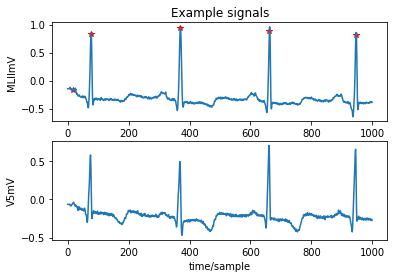

In [ ]:
example = "mitdb/100"
# example = "chfdb/chf01"
# load a record using the 'rdrecord' function
ann_extension = "ecg" if "chfdb" in example else "atr"
record = wfdb.rdrecord(example, sampfrom=0, sampto=1000)
ann = wfdb.rdann(example, ann_extension, sampto=1000)


print(record.__dict__)
print(ann.__dict__)

# plot the record to screen
wfdb.plot_wfdb(record=record, title='Example signals', annotation=ann)

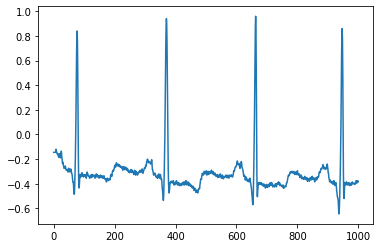

In [ ]:
plt.plot(record.p_signal[:, 0])

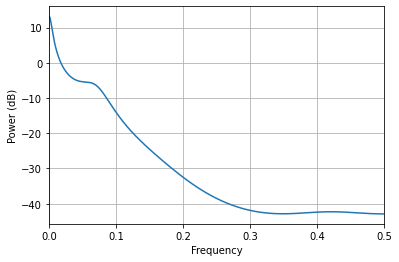

In [ ]:
p = spectrum.pburg(record.p_signal[:, 0], 7);  p.plot()

(4096,)


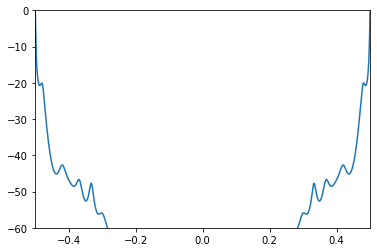

In [ ]:
AR, P, k = spectrum.arburg(record.p_signal[:, 0], 32)
PSD = spectrum.arma2psd(AR)
plot(linspace(-0.5, 0.5, len(PSD)), 10*log10(PSD/max(PSD)))

axis([-0.5,0.5,-60,0])
print(PSD.shape)

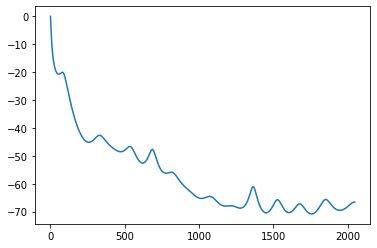

In [ ]:
plt.plot(10*log10(PSD[:2048]/max(PSD)))

# Extract Features

In [ ]:
features = []
targets = []
step = 500
for i in tqdm(range(100, 210)):
    try:
        for sampfrom in range(0, 20000, step):
            record = wfdb.rdrecord(f'mitdb/{i}', sampfrom=sampfrom, sampto=sampfrom+step)
            AR, P, k = spectrum.arburg(record.p_signal[:, 0], 32)
            PSD = spectrum.arma2psd(AR)
            features.append(10*log10(PSD[:2048]/max(PSD)))
            targets.append("Normal")
    except Exception as e:
        print(f"Failed {i}", end=",")

for i in tqdm(range(1, 16)):
    try:
        for sampfrom in range(0, 30000, step):
            record = wfdb.rdrecord(f'chfdb/chf{i:02d}', sampfrom=sampfrom, sampto=sampfrom+step)
            AR, P, k = spectrum.arburg(record.p_signal[:, 0], 32)
            PSD = spectrum.arma2psd(AR)
            features.append(10*log10(PSD[:2048]/max(PSD)))
            targets.append("CHF")
    except Exception as e:
        print(f"Failed {i}", end=",")
        print(e)

features = np.array(features)
targets = np.array(targets)

  0%|          | 0/110 [00:00<?, ?it/s]

Failed 110,Failed 120,Failed 125,Failed 126,Failed 127,Failed 128,Failed 129,Failed 130,Failed 131,Failed 132,Failed 133,Failed 134,Failed 135,Failed 136,Failed 137,Failed 138,Failed 139,Failed 140,Failed 141,Failed 142,Failed 143,Failed 144,Failed 145,Failed 146,Failed 147,Failed 148,Failed 149,Failed 150,Failed 151,Failed 152,Failed 153,Failed 154,Failed 155,Failed 156,Failed 157,Failed 158,Failed 159,Failed 160,Failed 161,Failed 162,Failed 163,Failed 164,Failed 165,Failed 166,Failed 167,Failed 168,Failed 169,Failed 170,Failed 171,Failed 172,Failed 173,Failed 174,Failed 175,Failed 176,Failed 177,Failed 178,Failed 179,Failed 180,Failed 181,Failed 182,Failed 183,Failed 184,Failed 185,Failed 186,Failed 187,Failed 188,Failed 189,Failed 190,Failed 191,Failed 192,Failed 193,Failed 194,Failed 195,Failed 196,Failed 197,Failed 198,Failed 199,Failed 204,Failed 206,

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
print(features.shape)
print(targets.shape)

(2140, 2048)
(2140,)


# Classification

In [ ]:
X, y = shuffle(features,targets)
y

array(['Normal', 'CHF', 'Normal', ..., 'Normal', 'Normal', 'Normal'],
      dtype='<U6')

In [ ]:
#CHF=0 and Normal= 1
y = np.unique(y, return_inverse=True)[1]
y

array([1, 0, 1, ..., 1, 1, 1])

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, cdist
from scipy.spatial.distance import squareform


def PUK_kernel(X1,X2, sigma=1.0, omega=1.0):
    # Compute the kernel matrix between two arrays using the Pearson VII function-based universal kernel.

    # Compute squared euclidean distance between each row element pair of the two matrices
    if X1 is X2 :
        kernel = squareform(pdist(X1, 'sqeuclidean'))
    else:
        kernel = cdist(X1, X2, 'sqeuclidean')

    kernel = (1 + (kernel * 4 * np.sqrt(2**(1.0/omega)-1)) / sigma**2) ** omega
    kernel = 1/kernel

    return kernel

  0%|          | 0/9 [00:00<?, ?it/s]


 KNeighborsClassifier(n_neighbors=1)
              precision    recall  f1-score   support

         CHF       0.98      0.96      0.97       190
      Normal       0.97      0.99      0.98       238

    accuracy                           0.98       428
   macro avg       0.98      0.98      0.98       428
weighted avg       0.98      0.98      0.98       428



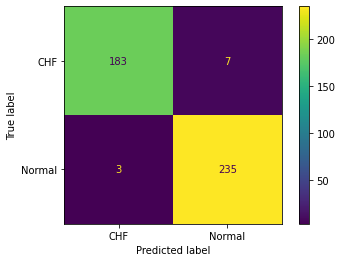

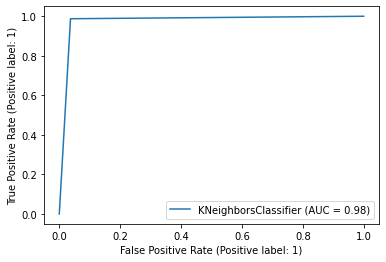


 KNeighborsClassifier(n_neighbors=3)
              precision    recall  f1-score   support

         CHF       0.97      0.96      0.97       190
      Normal       0.97      0.98      0.97       238

    accuracy                           0.97       428
   macro avg       0.97      0.97      0.97       428
weighted avg       0.97      0.97      0.97       428



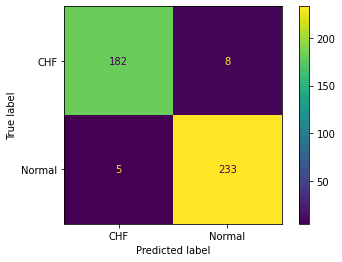

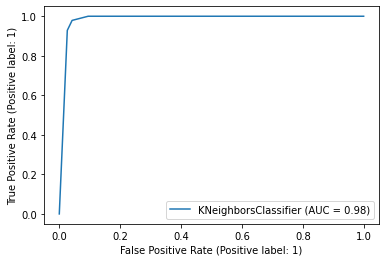


 KNeighborsClassifier()
              precision    recall  f1-score   support

         CHF       0.97      0.96      0.97       190
      Normal       0.97      0.98      0.97       238

    accuracy                           0.97       428
   macro avg       0.97      0.97      0.97       428
weighted avg       0.97      0.97      0.97       428



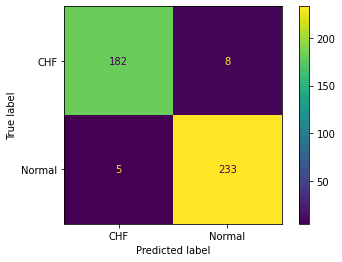

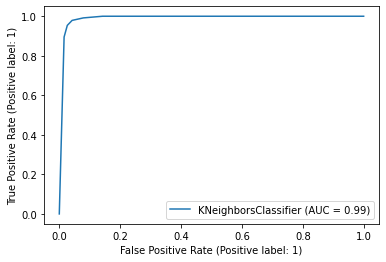


 KNeighborsClassifier(n_neighbors=7)
              precision    recall  f1-score   support

         CHF       0.97      0.95      0.96       190
      Normal       0.96      0.98      0.97       238

    accuracy                           0.97       428
   macro avg       0.97      0.97      0.97       428
weighted avg       0.97      0.97      0.97       428



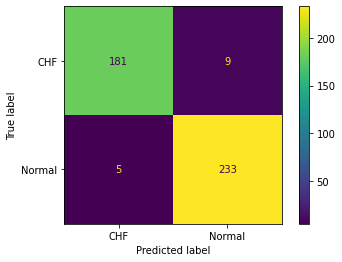

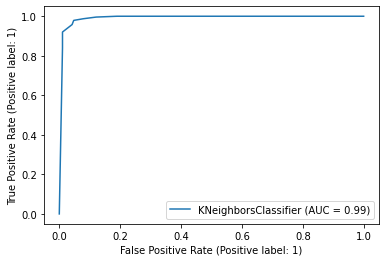


 KNeighborsClassifier(n_neighbors=10)
              precision    recall  f1-score   support

         CHF       0.96      0.95      0.95       190
      Normal       0.96      0.97      0.96       238

    accuracy                           0.96       428
   macro avg       0.96      0.96      0.96       428
weighted avg       0.96      0.96      0.96       428



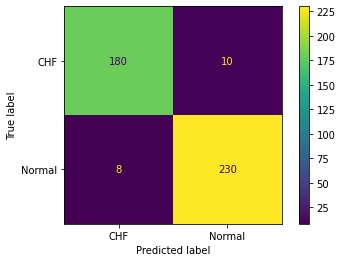

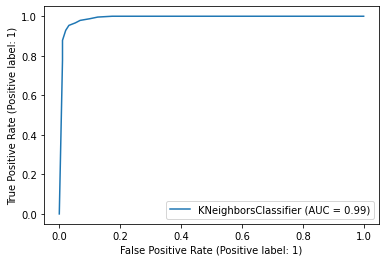

Iteration 1, loss = 18.10811074
Validation score: 0.414397
Iteration 2, loss = 9.71083096
Validation score: 0.414397
Iteration 3, loss = 10.40692125
Validation score: 0.585603
Iteration 4, loss = 5.75767155
Validation score: 0.585603
Iteration 5, loss = 3.29750574
Validation score: 0.587549
Iteration 6, loss = 2.56560750
Validation score: 0.616732
Iteration 7, loss = 2.39940373
Validation score: 0.412451
Iteration 8, loss = 2.08155418
Validation score: 0.463035
Iteration 9, loss = 1.63204509
Validation score: 0.591440
Iteration 10, loss = 1.75646766
Validation score: 0.614786
Iteration 11, loss = 1.50952530
Validation score: 0.535019
Iteration 12, loss = 1.11706091
Validation score: 0.614786
Iteration 13, loss = 0.82782401
Validation score: 0.642023
Iteration 14, loss = 0.67042293
Validation score: 0.480545
Iteration 15, loss = 0.87537125
Validation score: 0.494163
Iteration 16, loss = 0.72347364
Validation score: 0.538911
Iteration 17, loss = 0.79589369
Validation score: 0.688716
Iter

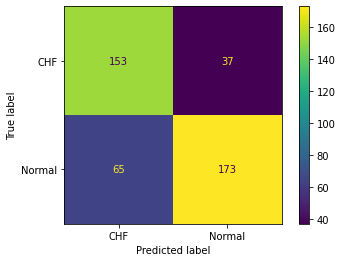

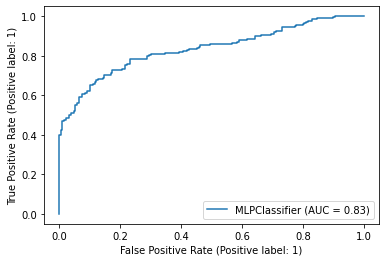


 SVC()
              precision    recall  f1-score   support

         CHF       0.99      0.98      0.98       190
      Normal       0.98      0.99      0.99       238

    accuracy                           0.99       428
   macro avg       0.99      0.99      0.99       428
weighted avg       0.99      0.99      0.99       428



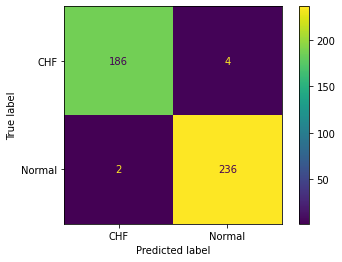

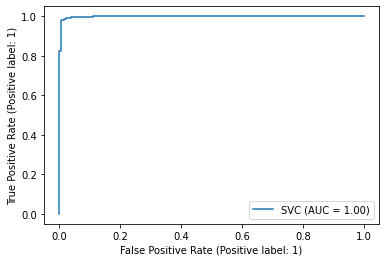


 SVC(kernel=<function PUK_kernel at 0x7fd9f5615dd0>)
              precision    recall  f1-score   support

         CHF       0.00      0.00      0.00       190
      Normal       0.56      1.00      0.71       238

    accuracy                           0.56       428
   macro avg       0.28      0.50      0.36       428
weighted avg       0.31      0.56      0.40       428



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


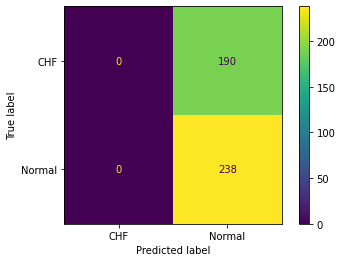

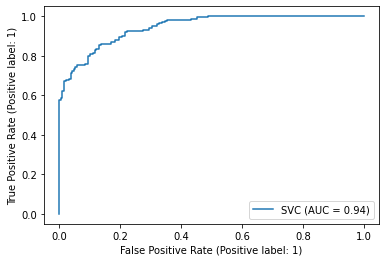


 RandomForestClassifier(max_features=6, n_estimators=20)
              precision    recall  f1-score   support

         CHF       0.96      0.96      0.96       190
      Normal       0.97      0.97      0.97       238

    accuracy                           0.96       428
   macro avg       0.96      0.96      0.96       428
weighted avg       0.96      0.96      0.96       428



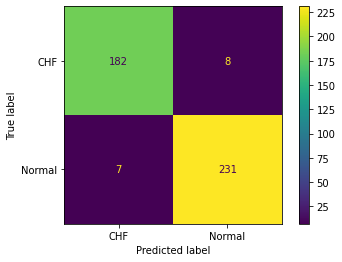

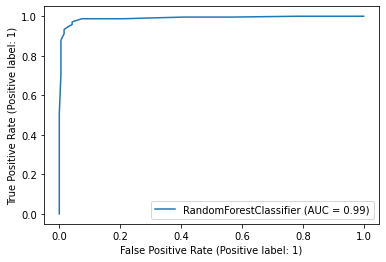

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
classifiers = [
    KNeighborsClassifier(1),
    KNeighborsClassifier(3),
    KNeighborsClassifier(5),
    KNeighborsClassifier(7),
    KNeighborsClassifier(10),
    MLPClassifier(max_iter=500, early_stopping=True, learning_rate_init=0.001, 
                  validation_fraction=0.3,
                  verbose=True, hidden_layer_sizes=(100, 100)),
    SVC(kernel="rbf") ,
    SVC(kernel=PUK_kernel),
    RandomForestClassifier(n_estimators = 20,max_features=6)          
]


def eval(X_test,y_true, y_pred, clf=""):
    cr = classification_report(y_true, y_pred, target_names=['CHF','Normal'])
    print(cr)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['CHF','Normal'])
    disp.plot()
    svc_disp = RocCurveDisplay.from_estimator(clf, X_test, y_test)
    plt.show()

for clf in tqdm(classifiers):
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    print("\n", clf)
    eval(X_test,y_test, y_pred, clf)